### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

![image.png](attachment:image.png)

In [1]:

import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


# llm=ChatGroq(model="qwen-2.5-32b")
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BPasFu7Lkn8xRlw5CtClSLUhvrvfk', 'finish_reason': 'stop', 'logprobs': None}, id='run-d091e92e-1b59-4e23-91d2-0dac4e9acce6-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["tag_line","use_cases","marketing_idea"]=Field(None,description="The next step in " \
    "the routing process")

# Augment the LLM with schema for structured output

router=llm.with_structured_output(Route)



In [4]:
#State

class State(TypedDict):
    input:str
    decision:str
    output:str

In [5]:


# Nodes
def llm_call_1(state:State):
    """Write a tag_line based on user input"""
    result=llm.invoke(state["input"])
    return {"output":result.content}

def llm_call_2(state: State):
    """Write a use_cases"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a marketing idea"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision=router.invoke(
        [SystemMessage(
            content="Route input to tag_line,use_case,marketing_idea based on the user's request"
        ),
        HumanMessage(content=state["input"]),]
    )
    return {"decision":decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state:State):
    if state["decision"]=="tag_line":
        return "llm_call_1"
    elif state["decision"]=="use_cases":
        return "llm_call_2"
    elif state["decision"]=="marketing_idea":
        return "llm_call_3"




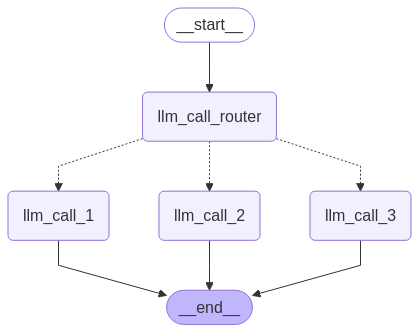

In [6]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
# Build workflow

router_builder=StateGraph(State)

#Add nodes
router_builder.add_node("llm_call_1",llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router",llm_call_router)

#add edges to connect nodes

router_builder.add_edge(START,"llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        # Name returned by route_decision : Name of next node to visit
        "llm_call_1":"llm_call_1",
         "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    }
)


router_builder.add_edge("llm_call_1",END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)
#compile workflow

router_workflow=router_builder.compile()

#show the workflow

display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [7]:
#invoke
state=router_workflow.invoke({"input":"Create use cases for Apple Iphone with AI"})

LLM call 2 is called


In [8]:
print(state["output"])

Certainly! The integration of artificial intelligence (AI) into the iPhone opens up a wide array of use cases that can enhance user experience, productivity, and personalization. Here are several illustrative use cases for AI on an iPhone:

1. **Personalized Siri Assistant**: 
   - **Contextual Awareness**: Siri can provide context-aware suggestions and reminders based on the user’s habits and location, such as advising when to leave for a meeting based on traffic conditions.
   - **Voice Customization**: AI can adapt Siri’s voice responses to match the user’s preferences or even create a custom voice profile from a short voice sample.

2. **Camera Enhancements**:
   - **Advanced Photo Editing**: AI-driven editing features that automatically improve photo quality, enhance color accuracy, and even remove unwanted objects from images.
   - **Smart Suggestions**: Recognition of scenes, people, and objects, prompting users with settings or filters best suited for capturing the moment.

3. 

In [9]:
#invoke
state=router_workflow.invoke({"input":"Create marketing idea for Apple Iphone with AI"})

In [10]:
state

{'input': 'Create marketing idea for Apple Iphone with AI',
 'decision': 'marketing_idea',
 'output': '**Marketing Campaign: "Intelligence in Your Hand"**\n\n**Campaign Overview:**\nThe "Intelligence in Your Hand" campaign emphasizes the integration of AI-powered features in the latest iPhone, showcasing how artificial intelligence can seamlessly enhance everyday experiences for users. The campaign will highlight innovative AI capabilities that set the iPhone apart, making it an indispensable tool for modern life.\n\n**Key Features to Highlight:**\n\n1. **Smart Photography:**\n   - AI-driven camera enhancements for perfect photos every time.\n   - Feature photographer testimonials showing the versatility of AI in various environments.\n   - Interactive online gallery comparing AI-enhanced photos to standard ones.\n\n2. **Personalized User Experience:**\n   - Adaptive learning features that customize apps and settings based on user behavior.\n   - Testimonials from users on how AI has t

### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

![image.png](attachment:image.png)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

![image.png](attachment:image.png)